In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install nlpaug
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.9 MB/s eta 0:00:00


In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
# import nlpaug.augmenter.word as naw
# import nltk
# nltk.download('averaged_perceptron_tagger_eng')
# import keras_tuner as kt

In [4]:
train = pd.read_csv("./CSV-Dataset/with-remove-stopwords/train_data.csv")
test = pd.read_csv("./CSV-Dataset/with-remove-stopwords/test_data.csv")

In [5]:
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (8507, 2)
Test Shape: (2127, 2)


In [6]:
train['labels'].value_counts()

labels
Ketenagakerjaan dan Kesejahteraan Sosial    1650
Kepegawaian                                 1265
Kesehatan                                   1149
Pendidikan                                   955
Perizinan dan Pertanahan                     891
Infrastruktur dan Fasilitas Umum             796
Teknologi Informasi dan Komunikasi           673
Keadilan Hukum dan HAM                       629
Lingkungan Hidup                             499
Name: count, dtype: int64

# **LSTM**

In [7]:
# Data preparation
train_texts = train['combined'].astype(str).tolist()
test_texts = test['combined'].astype(str).tolist()
train_labels = train['labels'].astype(str).tolist()
test_labels = test['labels'].astype(str).tolist()

In [ ]:
# # Augmentation
# aug = naw.SynonymAug(aug_src='wordnet')
# augmented_texts = [aug.augment(text) for text in train_texts]
# train_texts += augmented_texts  # Combine original and augmented data
# train_labels += train_labels  # Duplicate labels for augmented data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_texts + test_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [9]:
# Padding
max_sequence_length = 200
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [10]:
print("Encoded Labels:", train_labels_encoded)
print("Mapping (Label -> Angka):")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Encoded Labels: [7 8 5 ... 7 3 3]
Mapping (Label -> Angka):
Infrastruktur dan Fasilitas Umum -> 0
Keadilan Hukum dan HAM -> 1
Kepegawaian -> 2
Kesehatan -> 3
Ketenagakerjaan dan Kesejahteraan Sosial -> 4
Lingkungan Hidup -> 5
Pendidikan -> 6
Perizinan dan Pertanahan -> 7
Teknologi Informasi dan Komunikasi -> 8


In [ ]:
# Hyperparameter tuning with Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(
        Embedding(
            input_dim=5000,
            output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
            input_length=max_sequence_length
        )
    )
    model.add(BatchNormalization())
    model.add(
        Bidirectional(
            LSTM(
                units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),
                dropout=hp.Choice('dropout', [0.2, 0.3, 0.4]),
                recurrent_dropout=hp.Choice('recurrent_dropout', [0.2, 0.3, 0.4])
            )
        )
    )
    model.add(Dropout(hp.Choice('dense_dropout', [0.3, 0.4, 0.5])))
    model.add(Dense(units=9, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameter search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='/content/drive/MyDrive/Deep Learning/Final Project/Public Complaint Project/Model/lstm/hyperparam_tuning',
    project_name='lstm_text_classification'
)

tuner.search(train_padded, train_labels_encoded, epochs=5, validation_split=0.2)

Trial 3 Complete [00h 13m 52s]
val_accuracy: 0.8454759120941162

Best val_accuracy So Far: 0.8454759120941162
Total elapsed time: 00h 38m 39s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
256               |64                |embedding_dim
192               |128               |lstm_units
0.2               |0.3               |dropout
0.2               |0.4               |recurrent_dropout
0.5               |0.5               |dense_dropout
0.01              |0.001             |learning_rate

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 149s 683ms/step - accuracy: 0.2843 - loss: 2.0556 - val_accuracy: 0.5781 - val_loss: 1.2617
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 199s 669ms/step - accuracy: 0.5375 - loss: 1.4200 - val_accuracy: 0.6533 - val_loss: 1.0479
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 202s 672ms/step - accuracy: 0.5689 - loss: 1.3000 - val_accuracy: 0.7133 - val_loss: 0.9501
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 201s 667ms/step - accuracy: 0.6164 - l

In [ ]:
import json

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters = {
    'embedding_dim': best_hps.get('embedding_dim'),
    'lstm_units': best_hps.get('lstm_units'),
    'dropout': best_hps.get('dropout'),
    'recurrent_dropout': best_hps.get('recurrent_dropout'),
    'dense_dropout': best_hps.get('dense_dropout'),
    'learning_rate': best_hps.get('learning_rate')
}

with open('/content/drive/MyDrive/Deep Learning/Final Project/Public Complaint Project/Model/lstm/hyperparam_tuning/best_hyperparameters.json', 'w') as json_file:
    json.dump(best_hyperparameters, json_file, indent=4)

print(best_hyperparameters)

In [ ]:
# # Build the best model
# best_hps = tuner.get_best_hyperparameters()[0]
# model = tuner.hypermodel.build(best_hps)

# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# # Train the model
# history = model.fit(
#     train_padded, train_labels_encoded,
#     epochs=20,  # Increased due to early stopping
#     batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stopping, reduce_lr]
# )

# # Evaluate the model
# loss, accuracy = model.evaluate(test_padded, test_labels_encoded, verbose=0)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [ ]:
# Set hyperparameters
embedding_dim = 64
lstm_units = 128
dropout = 0.3
recurrent_dropout = 0.4
dense_dropout = 0.5
learning_rate = 0.001

# Build the model
model = Sequential([
    # Embedding layer
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_sequence_length),

    # LSTM layer
    LSTM(lstm_units, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False),

    # Fully connected layer with dropout
    Dense(128, activation='relu'),
    Dropout(dense_dropout),

    # Output layer
    Dense(9, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_padded, train_labels_encoded,
    epochs=20,  # Using early stopping
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels_encoded, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 94s 396ms/step - accuracy: 0.2161 - loss: 2.0445 - val_accuracy: 0.5159 - val_loss: 1.3459 - learning_rate: 0.0010
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 135s 395ms/step - accuracy: 0.5639 - loss: 1.2664 - val_accuracy: 0.7227 - val_loss: 0.8655 - learning_rate: 0.0010
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 84s 397ms/step - accuracy: 0.7313 - loss: 0.8387 - val_accuracy: 0.7626 - val_loss: 0.7460 - learning_rate: 0.0010
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 84s 396ms/step - accuracy: 0.7922 - loss: 0.6662 - val_accuracy: 0.7850 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 143s 399ms/step - accuracy: 0.8535 - loss: 0.5145 - val_accuracy: 0.7756 - val_loss: 0.7540 - learning_rate: 0.0010
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8817 - loss: 0.4027
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
213/213 ━━━━━━━━━━━━━━━━━━━━ 139s 385ms/step - accuracy: 0.

In [ ]:
history_dict = {
    'train_loss': history.history['loss'],
    'train_accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}

output_path = '/content/drive/MyDrive/Deep Learning/Final Project/Public Complaint Project/Model/lstm/training_history.json'

# Save to JSON file
with open(output_path, 'w') as json_file:
    json.dump(history_dict, json_file, indent=4)

In [ ]:
history_dict

{'train_loss': [1.8380322456359863,
  1.1626842021942139,
  0.8245797157287598,
  0.6548864841461182,
  0.5005740523338318,
  0.42528313398361206,
  0.33622458577156067],
 'train_accuracy': [0.30668625235557556,
  0.607200562953949,
  0.7397502064704895,
  0.8013225793838501,
  0.851432740688324,
  0.8755326867103577,
  0.9008082151412964],
 'val_loss': [1.345911979675293,
  0.8655207753181458,
  0.7460189461708069,
  0.7068309783935547,
  0.7540392875671387,
  0.7614143490791321,
  0.7809151411056519],
 'val_accuracy': [0.5158637166023254,
  0.7226791977882385,
  0.7626321911811829,
  0.7849588990211487,
  0.7755581736564636,
  0.7837837934494019,
  0.7849588990211487]}

In [ ]:
# Classification report
predictions = np.argmax(model.predict(test_padded), axis=1)
print(classification_report(test_labels_encoded, predictions, target_names=label_encoder.classes_))

# Save the model
model.save('./lstm/lstm_model.h5')

67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step


                                          precision    recall  f1-score   support

        Infrastruktur dan Fasilitas Umum       0.80      0.88      0.84       187
                  Keadilan Hukum dan HAM       0.58      0.47      0.52       163
                             Kepegawaian       0.78      0.88      0.83       316
                               Kesehatan       0.79      0.76      0.77       263
Ketenagakerjaan dan Kesejahteraan Sosial       0.87      0.82      0.85       440
                        Lingkungan Hidup       0.64      0.54      0.58       115
                              Pendidikan       0.80      0.84      0.82       243
                Perizinan dan Pertanahan       0.83      0.81      0.82       226
      Teknologi Informasi dan Komunikasi       0.78      0.84      0.81       174

                                accuracy                           0.79      2127
                               macro avg       0.76      0.76      0.76      2127
              

In [12]:
# Load the saved model
model = load_model('./lstm/lstm_model.h5')

predictions = model.predict(test_padded)

I0000 00:00:1732791405.972295   42628 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732791406.092052   42628 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732791406.092134   42628 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732791406.116814   42628 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732791406.116885   42628 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step


In [13]:
# Mengonversi probabilitas ke label kelas dengan argmax
predicted_labels = np.argmax(predictions, axis=1)

# Sekarang, Anda dapat menghitung metrik evaluasi dengan label yang sudah diprediksi
acc = accuracy_score(test_labels_encoded, predicted_labels)
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')

print("Accuracy:", acc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

Accuracy: 0.7903149976492713
Recall: 0.7903149976492713
Precision: 0.7871635931606078
F1 Score: 0.7871687218378228


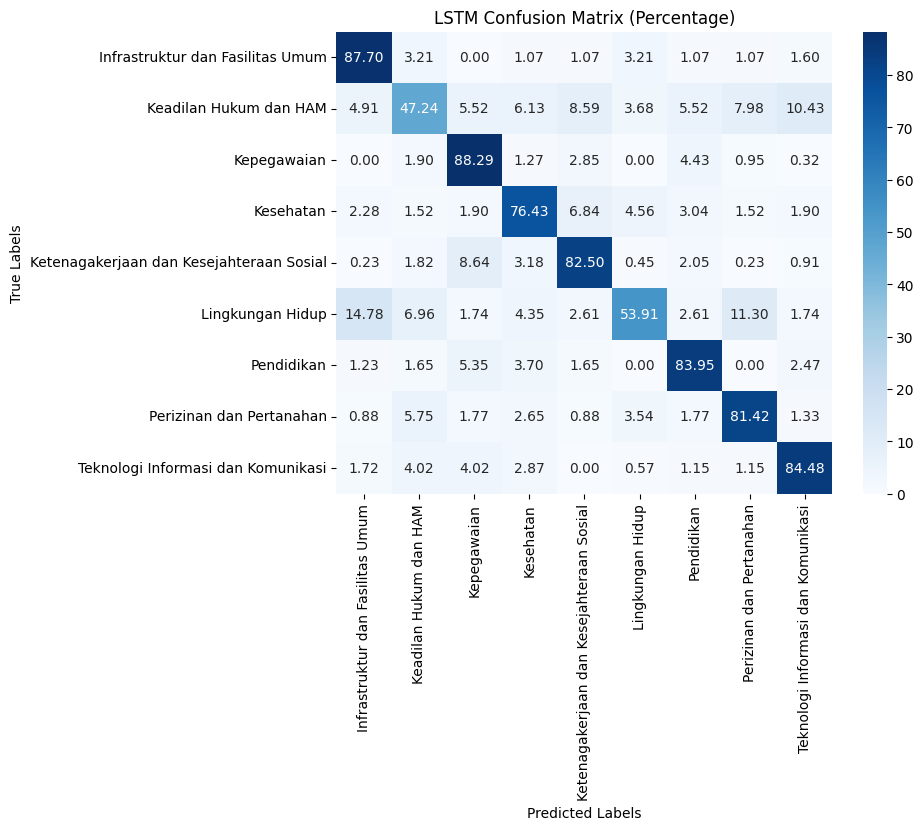

In [22]:
cm = confusion_matrix(test_labels_encoded, predicted_labels)

# Calculate the percentage for each cell
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix as percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("LSTM Confusion Matrix (Percentage)")
plt.show()

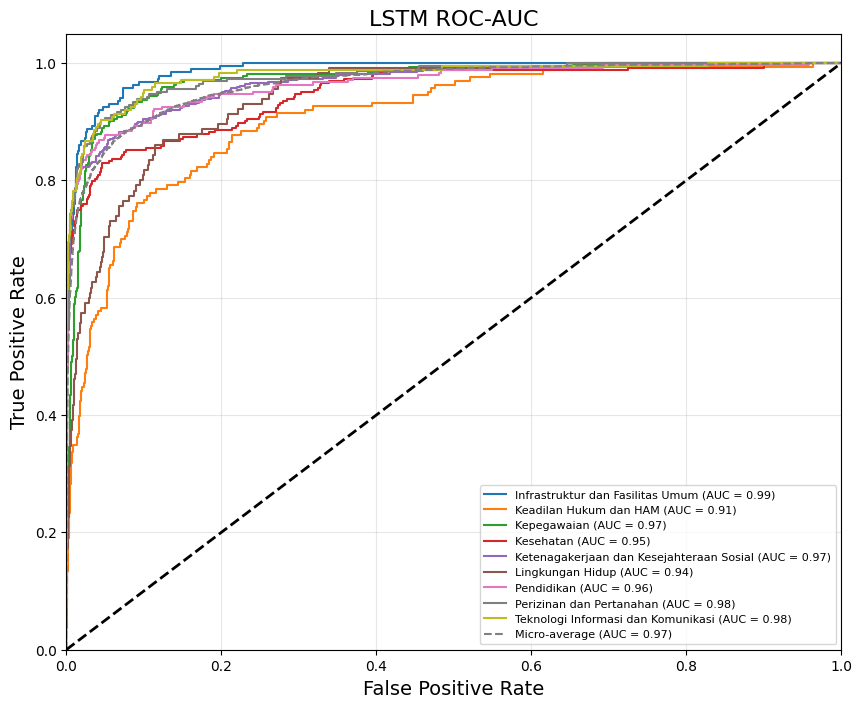

In [24]:
probabilities = softmax(predictions, axis=1)

# Hitung jumlah kelas
n_classes = probabilities.shape[1]

# Binarisasi label test
test_labels_binarized = label_binarize(test_labels_encoded, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_binarized.ravel(), probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10.colors  # Use a colormap for better visualization

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"], linestyle="--", color="gray",
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('LSTM ROC-AUC', fontsize=16)
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.show()